# TextCNN
## Классификация текстов через сверточную нейронную сеть с использованием векторных представлений слов.

In [1]:
# Предустановка необходимых зависимостей
%pip install -Ur requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import torch.nn as nn
import numpy as np

### Fasttext
Для решения задачи будем использовать предобученные легковесные векторные представления _glove_ размера 25.

In [2]:
import gensim.downloader as api


fasttext = api.load('glove-twitter-25')

In [7]:
fasttext.most_similar(positive=['news'])

[('bbc', 0.9295514822006226),
 ('uk', 0.9242048859596252),
 ('yahoo', 0.8797301054000854),
 ('press', 0.875943124294281),
 ('report', 0.8702858090400696),
 ('group', 0.859866738319397),
 ('japan', 0.8509190082550049),
 ('latest', 0.850569486618042),
 ('’s', 0.8463255167007446),
 ('abc', 0.8438911437988281)]

In [8]:
fasttext.most_similar(positive=['news', 'usa'], negative=['canada'])

[('video', 0.8424751162528992),
 ('tv', 0.8422137498855591),
 ('google', 0.8344797492027283),
 ('via', 0.8309010863304138),
 ('mp', 0.8272317051887512),
 ('fox', 0.814910888671875),
 ('facebook', 0.8100445866584778),
 ('youtube', 0.7995398640632629),
 ('cd', 0.7935119867324829),
 ('web', 0.7915233373641968)]

In [5]:
# Импортируем все необходимое для предобработки текстов и создадим 

import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10): # укажем в конструкторе минимальную частоту для слов в словаре, воизбежании использования редких слов
        
        # Соединим все тексты и уберем все лишнее, приведем к одному регистру и посчитаем кол-во вхождений слов.
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)
        
        # Оставим только частовстречаемые слова

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>') # Добавим уникальный токен для неизвестных слов
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)} # Создадим словари соответствия для токенизации текстов из числа в слово
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)} # И из слова в число

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>' # Возвращаем уникальный токен в случае если слово отсутствует в словаре

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>'] # Возвращаем уникальный токен в случае если слово отсутствует в словаре

        return self._word2idx[word]
    
    def encode(self, text):
        # Кодирование предложения в последовательность токенов
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        # Создание матрицы векторов слов из словаря
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

###  Классификация тексов на примере отзывов на кинокартины с IMDB

In [6]:
import pandas as pd


df = pd.read_csv('IMDB Dataset.csv')

In [7]:
text = df['review'][0]

In [8]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Для сырых данных необходимо создать кастомный класс Dataset для работы с PyTorch

In [35]:
from torch.utils.data import Dataset


class IMDB(Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path) # Считаем датафрейм по пути
        
        texts = self.df['review'].values # Выделим тексты

        self.vocab = Vocabulary(texts, min_freq=5) # Используем ранее созданый класс для формирования словаря с минимальной частотой слов 5

        self.label2idx = {'positive': 0, 'negative': 1} # Переведем категориальные признаки в числа 0 и 1

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text)) # Используем метод класса словаря для токенизации текста
        label = torch.FloatTensor([label]) # Обучать сеть будем на BCELoss соответственно пример таргет вещественным значением

        return text, label

    def __len__(self):
        return len(self.df)

In [37]:
dataset = IMDB('IMDB Dataset.csv')

In [36]:
dataset[0]

(tensor([30504., 10253.,  9172.,  1964., 17895., 10316., 21092., 18613., 26204.,
          6893.,  8916., 39272., 30114., 38144., 39272., 27292., 39272.,  1394.,
         23728., 39272., 26999., 25378.,   316.,  7996., 13440., 13822.,  7174.,
         39272., 39272., 39272., 26049., 15277., 18613., 25709., 27419., 13821.,
         30114., 18285., 24789.,  9943., 30023., 30298., 14246., 10253., 39272.,
         26577., 30662., 26279., 20109., 13968.,  9172., 29793., 39272., 25979.,
         39272., 25378.,   316., 27375., 22353., 30626., 35070.,  9172., 10353.,
          7867.,  5593., 39272., 25378., 30626.,   106., 21910., 25080.,  7174.,
          4019., 17060., 39272.,  7579.,  5593., 39272., 24789.,   316., 39272.,
         26279.,  9172., 19337., 27676., 10253.,  9172., 39272., 39272., 39272.,
           316., 31999., 30114., 26999., 18613.,   316.,  9172., 23241., 22053.,
         17060.,  9172.,  6656.,  2333., 17349., 14291., 39272., 22821., 24384.,
          5914.,  1226., 181

### Определим тестовые и обучающую выборки

In [38]:
from torch.utils.data import random_split


train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

### Формирование батчей объектов

Так как тексты имеют переменную длинну и нет возможности стакать тензоры разной длинны, а подавать объекты по одному очень долго - воспользуемся _**pad_sequence**_ для допаживания текстов до длинны равной длине максимально текста в батче.

In [39]:
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

### Создание даталоадеров

In [40]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [41]:
b = next(iter(train_loader))

In [43]:
b

(tensor([[21847, 39272, 33222,  ..., 39273, 39273, 39273],
         [25305, 37879, 17060,  ..., 39273, 39273, 39273],
         [25378, 21043, 37043,  ..., 39273, 39273, 39273],
         ...,
         [39210,   316, 22353,  ..., 39273, 39273, 39273],
         [ 7526, 33721,   316,  ..., 39273, 39273, 39273],
         [ 9172,  6998, 36125,  ..., 39273, 39273, 39273]]),
 tensor([[0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],


In [44]:
b[0]

tensor([[21847, 39272, 33222,  ..., 39273, 39273, 39273],
        [25305, 37879, 17060,  ..., 39273, 39273, 39273],
        [25378, 21043, 37043,  ..., 39273, 39273, 39273],
        ...,
        [39210,   316, 22353,  ..., 39273, 39273, 39273],
        [ 7526, 33721,   316,  ..., 39273, 39273, 39273],
        [ 9172,  6998, 36125,  ..., 39273, 39273, 39273]])

### Соберем сеть

In [45]:
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx) # Воспользуемся слоем эмбединг для создания матрицы словаря

        self.convs = nn.ModuleList( # Создадим набор сверток
            [
                nn.Conv2d(
                    in_channels=1,
                    out_channels=32, # Будем искать 32 паттерна
                    kernel_size=(fs, embedding_dim)) # С ядрами размер_фильтра Х размерность_эмбедингов
                for fs in [2, 3, 4, 5, 6]
            ]
        )

        self.fc = nn.Linear(5 * 32, 1) # Линейный слой в качестве головы

        self.dropout = nn.Dropout(0.5) # Добавим дропаут для обобщенности в избежания переобучения

    def forward(self, x):
        x = self.embedding(x) # Получим матрицу эмбедингов
        
        x = x.unsqueeze(1) # Добавим размерность для последующих операций

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] # Пропустим получившийся набор эмбедингов через свертки, активацию и уберем добавленную размерность

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x] # Макспуллинг перед полносвязыным слоем

        x = self.dropout(torch.cat(x, dim = 1)) # Конкатим результаты сверточных слоев

        return self.fc(x)

## Обучим модель

In [46]:
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [47]:
vectors = dataset.vocab.build_vectors(fasttext)

In [48]:
vectors.shape

(39273, 25)

In [49]:
model.embedding.weight.shape

torch.Size([39274, 25])

### Загрузка предобученных векторов в слой эмбединга

In [50]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [51]:
model.embedding.weight

Parameter containing:
tensor([[-0.8029,  0.3492, -0.1870,  ..., -0.5928, -0.3013, -0.0089],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2194,  0.8999, -0.3627,  ...,  0.4955,  0.2587,  0.0560],
        ...,
        [-0.5925, -0.5153, -0.5562,  ..., -1.2555, -0.1518, -0.9410],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [52]:
model.embedding.weight.shape

torch.Size([39274, 25])

### Определем функции для обучения

In [69]:
from tqdm import tqdm


def binary_accuracy(preds, y):
    # Точность бинарной классификации принимает прогноз и фактический таргет
    rounded_preds = torch.round(torch.sigmoid(preds)) # Возьмем сигмойду от прогноза и округлим
    correct = (rounded_preds == y).float() # Считаем корректные прогнозы
    acc = correct.sum() / len(correct) # Считаем долю корректных прогнозов
    return acc


def train(model) -> float:
    model.train() # Переводим модель в режим обучения

    train_loss = 0 # Считаем лосс
    train_accuracy = 0 # Считаем точность

    for x, y in tqdm(train_loader, desc='Train'): # Итерируемся по даталоадеру
        x, y = x.to(device), y.to(device) # Перемещаемся на GPU

        optimizer.zero_grad() # Обнуляем градиенты

        output = model(x) # Считаем выход модели

        loss = loss_fn(output, y) # Считаем ошибку

        train_loss += loss.item() # Добавляем к ошибке ранее
        train_accuracy += binary_accuracy(output, y) # Добавляем рассчитанную точность

        loss.backward() # Считаем градиенты

        optimizer.step() # Делаем шаг оптимизатора

    train_loss /= len(train_loader) # Усредняем ошибку по всем батчам
    train_accuracy /= len(train_loader) # Усредняем точность по всем батчам

    return train_loss, train_accuracy

In [54]:
@torch.inference_mode() # Оценка качества проводится в режиме инференса(без подсчета градиентов)
def evaluate(model, loader) -> tuple[float, float]:
    model.eval() 

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

### Визуализация обучения

In [68]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [56]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [57]:
import torch.nn as nn
from torch.optim import Adam

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
#print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cpu


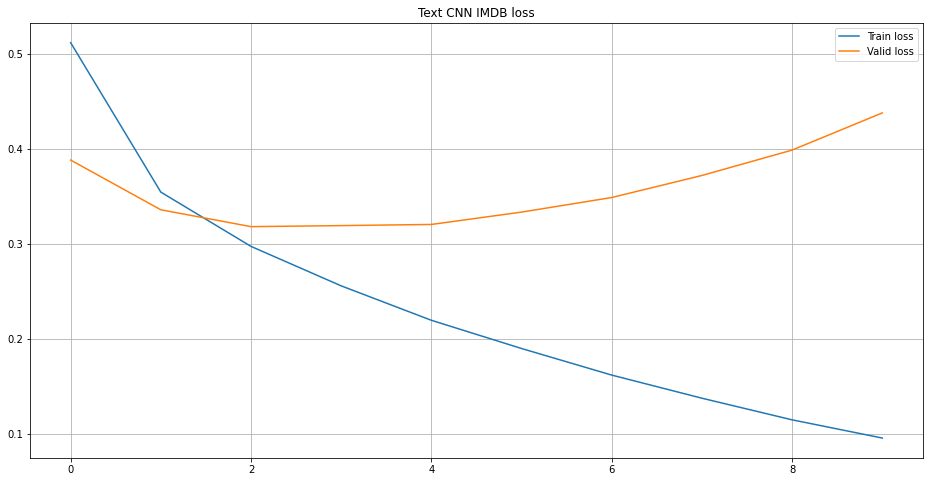

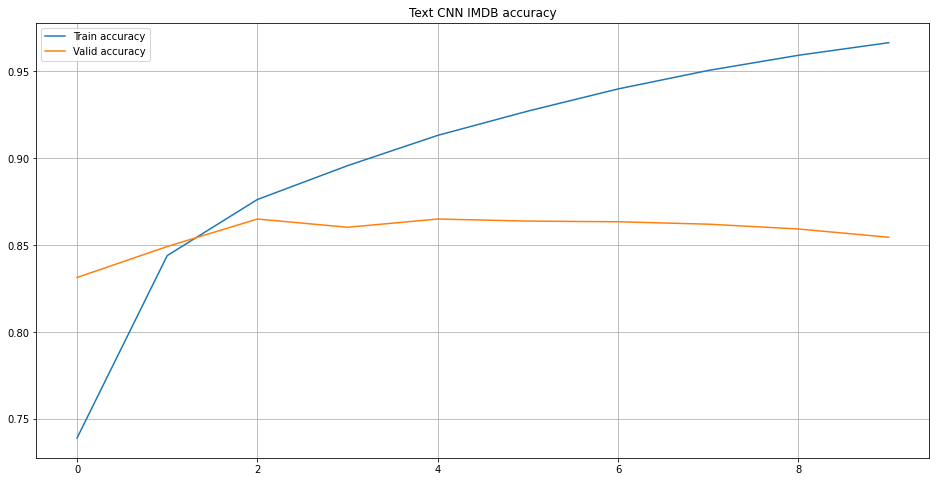

In [32]:
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 10, 'Text CNN IMDB')

Модель достаточно сильно переобучается начиная с 7ой эпохи. Но тем не менее качество достаточно высокое больше 85% на валидационной выборке. Во избежании переобучения можно добавить дропаутов и батч нормализацию.